# GLM: Ordinal Response

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython.display import display
from PIL import Image
from theano import shared
import arviz as az
from scipy.special import expit as logistic
from scipy.special import logit as Logit
import theano.tensor as tt

####  Unlike a count, the differences in value are not necessarily equal. It might be much harder to move someone’s preference for fish from 1 to 2 than it is to move it from 5 to 6. Just treating ordered categories as continuous measures is not a good idea.

#### This is just a multinomial prediction problem, but with the constraint that the categories be ordered demands a special treatment. What we’d like is for any associated predictor variable, as it increases, to move predictions progressively through the categories in sequence. So for example if preference for ice cream is positively associated with years of age, then the model should sequentially move predictions upwards as age increases: 3 to 4, 4 to 5, 5 to 6, etc. This presents a challenge: how to ensure that the linear model maps onto the outcomes in the right order.

#### The conventional solution is to use a cumulative link function.180 The cumulative probability of a value is the probability of that value or any smaller value. In the context of ordered categories, the cumulative probability of 3 is the sum of the probabilities of 3, 2, and 1. Ordered categories by convention begin at 1, so a result less than 1 has no probability at all. By linking a linear model to cumulative probability, it is possible to guarantee the ordering of the outcomes.

#### Data description:
#### The data is from a series of experiments conducted by philosophers with the aim of collecting evidence vis-a-vis debates on moral intuition, such measurements are obtained by using 'trolley problem' scenarios, e.g:

###### Standing by the railroad tracks, Dennis sees an empty, out-of-control boxcar about to hit five people. Next to Dennis is a lever that can be pulled, sending the boxcar down a side track and away from the five people. But pulling the lever will also lower the railing on a footbridge spanning the side track, causing one person to fall off the footbridge and onto the side track, where he will be hit by the boxcar. If Dennis pulls the lever the boxcar will switch tracks and not hit the five people, and the one person to fall and be hit by the boxcar. If Dennis does not pull the lever the boxcar will continue down the tracks and hit five people, and the one person will remain safe above the side track. 

In [2]:
def data_proc():
    
    def standardise(x):
        return (x-x.mean())/x.std()
    
    data = pd.read_csv(os.path.join(os.getcwd(),r'data/trolley.csv'), delimiter=";")

    return data

In [3]:
data = data_proc()
data.head()

,case,response,order,id,age,male,edu,action,intention,contact,story,action2
0,cfaqu,4,2,96;434,14,0,Middle School,0,0,1,aqu,1
1,cfbur,3,31,96;434,14,0,Middle School,0,0,1,bur,1
2,cfrub,4,16,96;434,14,0,Middle School,0,0,1,rub,1
3,cibox,3,32,96;434,14,0,Middle School,0,1,1,box,1
4,cibur,3,4,96;434,14,0,Middle School,0,1,1,bur,1


#### There are 12 columns and 9930 rows, comprising data for 331 unique individuals. The outcome we’ll be interested in is response, which is an integer from 1 to 7 indicating how morally permissible the participant found the action to be taken (or not) in the story.

Text(0, 0.5, 'Frequency')

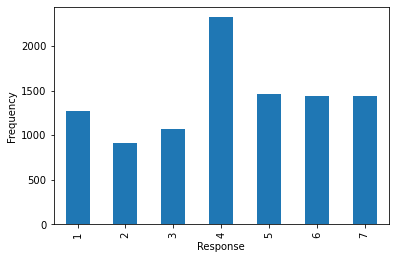

In [4]:
data.response.value_counts(sort=False).plot(kind='bar')
plt.xlabel("Response")
plt.ylabel("Frequency")

Text(0, 0.5, 'Cumulative Proportion')

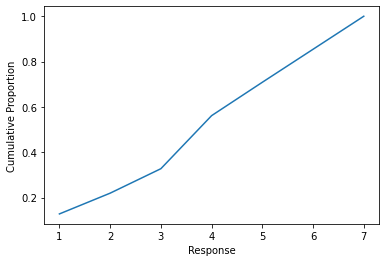

In [5]:
data.response.value_counts(normalize=True, sort=False).cumsum().plot()
plt.xlabel("Response")
plt.ylabel("Cumulative Proportion")

Text(0, 0.5, 'Log-cumulative odds')

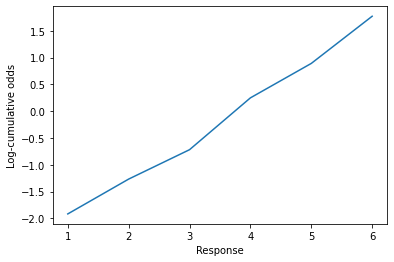

In [6]:
data.response.value_counts(normalize=True, sort=False).cumsum().apply(lambda x: np.log(x/(1-x))).plot()
plt.xlabel("Response")
plt.ylabel("Log-cumulative odds")

#### Our goal is to re-describe this histogram on the log-cumulative-odds scale. This just means constructing the odds of a cumulative probability and then taking a logarithm. Why do this arcane thing? Because this is the cumulative analog of the logit link we used in previous chapters. The logit is log-odds, and cumulative logit is log-cumulative-odds. Both are designed to constrain the probabilities to the 0/1 interval. Then when we decide to add predictor variables, we can safely do so on the cumulative logit scale. The link function takes care of converting the parameter estimates to the proper probability scale.

#### To model this we will need a series of intercept params, each intercept will be on the log-cumulative-odds scale and stand in for the cumulative probability of each outcome, the log-cumulative-odds that a response $y_{i}$ is equal to or less than some possible outcome $k$ is:
$$log (Pr(y_{i} \leq k)/1-Pr(y_{i} \leq k)) = \alpha_{k}$$

In [7]:
data.response.value_counts(normalize=True, sort=False).cumsum().apply(lambda x: np.log(x/(1-x)))

1   -1.916091
2   -1.266606
3   -0.718634
4    0.247786
5    0.889864
6    1.769381
7         NaN
Name: response, dtype: float64

#### Note that the cumulative log of the largest response 7 is infinite since $log(1/(1-1)) = \inf$. Since the largest response value always has the cumulative probability of 1, we do not need a parameter for it, so we get one for free so we only need $k-1 =6$ intercepts.

#### We now need a model, we need to account for sample size, prior information, insert predictors, use Bayes' theorem to compute the posterior distribution of these intercepts and compute the likelihood of each possible response value. In this last step we use cumulative probabilities $Pr(y_{i} \leq k)$ to compute the likelihood $Pr(y_{i} = k)$.

#### To do this, each intercept $\alpha_{k}$ implies a cumulative probability for each $k$. We can use the inverse link to translate from log-cumulative odds back to cumulative probability, so when $k$ is observed and we need its likelihood we can get it from substraction:
$$p_{k} = Pr(y_{i}=k) = Pr(y_{i} \leq k) - Pr(y_{i} \leq k-1)$$

#### Set up:
$$R_{i} \sim Ordered-logit(\phi_{i}, \kappa)$$ 

$$\phi_{i} = 0$$

$$\kappa_{k} \sim Normal(0, 1.5)$$

#### Equivalently and more exhaustively:
$$R_{i} \sim Categorical(p)$$

$$p_{1} = q_{1}$$

$$p_{k} = q_{k} - q_{k-1}$$

$$p_{k} = 1-q_{k-1}$$

$$logit(q_{k}) = \kappa_{k} - \phi_{i}$$

$$\phi_{i} = terms  of  the  linear  model$$

$$\kappa_{k} \sim Normal(0, 1.5)$$

#### The more tedious form exposes the fact that an ordered logit distribution is really just a categorical distribution that takes a vector $p = [p_{1},...,p_{6}]$ of probabilities of each response value below the maximum response (7 in this case). Each response $k$ in this vector is defined by its link to an intercept parameter $\alpha_{k}$. In addition some weakly regularising priors are place on these intrecepts.

In [8]:
with pm.Model() as m12_4:
    cuts = pm.Normal("cuts", 0.0, 1.5, transform=pm.distributions.transforms.ordered, shape=6, testval=np.arange(6)-2.5)
    R = pm.OrderedLogistic("R", 0.0, cuts, observed=data.response.values-1)
    
    trace_12_4 = pm.sample(random_seed = 8_927)

<ipython-input-8-33efc03c09fc>:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_12_4 = pm.sample(random_seed = 8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [cuts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
The acceptance probability does not match the target. It is 0.8932286689860123, but should be close to 0.8. Try to increase the number of tuning steps.


#### The posterior distribution of the cutputs is on the log-cumulative odds scale

In [9]:
az.summary(trace_12_4)

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cuts[0],-1.916,0.030,-1.976,-1.863,0.0,0.0,4256.0,3217.0,1.0
cuts[1],-1.266,0.024,-1.313,-1.221,0.0,0.0,4671.0,3643.0,1.0
cuts[2],-0.718,0.022,-0.758,-0.676,0.0,0.0,4655.0,3655.0,1.0
cuts[3],0.249,0.020,0.210,0.285,0.0,0.0,4502.0,3369.0,1.0
cuts[4],0.890,0.022,0.851,0.933,0.0,0.0,5100.0,3277.0,1.0
cuts[5],1.770,0.028,1.716,1.822,0.0,0.0,5329.0,3625.0,1.0


#### To get cumulative probabilities back for each cutpoint 1 to 6.

In [10]:
def _logit(x):
    return x/(1+np.exp(x))

In [11]:
{i:logistic(j) for i, j in zip(range(1,7),(trace_12_4["cuts"]).mean(0))}

{1: 0.12829348110338737,
 2: 0.2198945576468553,
 3: 0.32777544143583587,
 4: 0.5618143637801738,
 5: 0.7089354603929046,
 6: 0.8544064058018969}

#### Adding predictors

#### We now augment the above model accordingly:

$$log (Pr(y_{i} \leq k)/1-Pr(y_{i} \leq k)) = \alpha_{k} - \phi_{i}$$

$$\phi_{i} = \beta x_{i}$$

#### This structure automatically ensures the correct ordering of outcome values while still morphing the likelihood of each individual value as the predictor $x_{i}$ changes value. $\phi_{i}$ is subtracted from the intercept so that if we decrease the log-cumulative odds of every outcome value $k$ below the max, this shifts probability mass upwards towards higher outcome values. So then positive values of $\beta$ mean increasing $x$ also increases the mean of $y$. 

#### The predictor variables of interest are going to be action, intention, and contact, each an indicator variable corresponding to each principle outlined earlier. There are several ways we could code these indicator variables into treatments. Consider that contact always implies action. The way that contact is coded here, it excludes action, treating the two features as mutually exclusive. But each can be combined with intention. This gives us 6 possible story combinations: 
##### (1) No action, contact, or intention
##### (2) Action
##### (3) Contact
##### (4) Intention
##### (5) Action and intention
##### (6) Contact and intention

#### The model set up:
$$log (Pr(y_{i} \leq k)/1-Pr(y_{i} \leq k)) = \alpha_{k} - \phi_{i}$$

$$\phi_{i} = \beta_{A} A_{i} + \beta_{C}C_{i} + \beta_{I,i} I_{i}$$

$$B_{I,i} = \beta_{I} + \beta_{IA} A_{i} + \beta_{IC} C_{i}$$

#### Where $A_{i}$ is the value of action on row $i$, $I_{i}$ is intention, $C_{i}$ indicates the value of contact and the interactions of intention with action and contact are subsumed into the auxiliary linear model $B_{I}$.

In [12]:
R = data.response.values - 1

with pm.Model() as m12_5:
    cuts = pm.Normal("cuts", 0.0, 1.5, transform=pm.distributions.transforms.ordered, shape=6, testval=np.arange(6)-2.5)
    bA = pm.Normal("bA", 0.0, 0.5)
    bC = pm.Normal("bC", 0.0, 0.5)
    bI = pm.Normal("bI", 0.0, 0.5)
    bIA = pm.Normal("bIA", 0.0, 0.5)
    bIC = pm.Normal("bIC", 0.0, 0.5)
    
    A = pm.Data("A", data.action.values)
    I = pm.Data("I", data.intention.values)
    C = pm.Data("C", data.contact.values)
    
    BI = bI + bIA*A + bIC*C
    phi = pm.Deterministic("phi", bA*A + bC*C + BI*I)
    
    resp_obs = pm.OrderedLogistic("resp_obs", phi, cuts, observed=R)
    
    trace_12_5 = pm.sample(random_seed = 8_927)

<ipython-input-12-b1a6da3f96dc>:20: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_12_5 = pm.sample(random_seed = 8_927)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [bIC, bIA, bI, bC, bA, cuts]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 305 seconds.


In [13]:
idata = az.from_pymc3(trace_12_5)
az.summary(idata, var_names=["bIC", "bIA", "bC", "bI", "bA"])

/home/mspil/miniconda3/envs/pymc_env/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
bIC,-1.233,0.098,-1.417,-1.052,0.002,0.001,2429.0,2797.0,1.0
bIA,-0.431,0.081,-0.573,-0.270,0.002,0.001,2379.0,2673.0,1.0
bC,-0.344,0.068,-0.465,-0.215,0.001,0.001,2517.0,2942.0,1.0
bI,-0.293,0.059,-0.406,-0.185,0.001,0.001,2307.0,2420.0,1.0
bA,-0.473,0.055,-0.572,-0.369,0.001,0.001,2367.0,2830.0,1.0


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

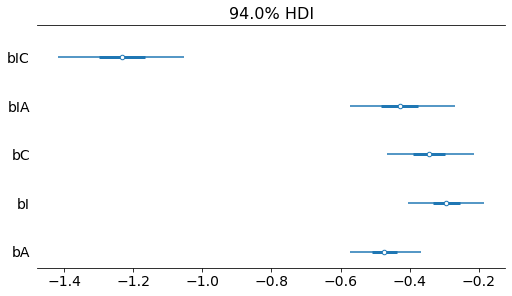

In [14]:
az.plot_forest(idata, var_names=["bIC", "bIA", "bC", "bI", "bA"], figsize=(7,4), combined=True)

#### The posterior distributions of the slopes are reliably negative, so each of these story features reduces the rating. The combination of intention and contact is the worst. This is curious, because it seems that neither intention nor contact by itself has a large impact on ratings.

#### Plotting implied histogram of outcomes

In [15]:
# counterfactual cases

cases_df = pd.DataFrame(
    np.array([[0, 0, 0], [0, 0, 1], [1, 0, 0], [1, 0, 1], [0, 1, 0], [0, 1, 1]]), columns=["action", "contact", "intention"],)

cases_df

,action,contact,intention
0,0,0,0
1,0,0,1
2,1,0,0
3,1,0,1
4,0,1,0
5,0,1,1


In [34]:
#observed cumulative probabilities

p_obs = data.groupby(["action", "contact", "intention"]).response.value_counts(normalize=True, sort=False).unstack().cumsum(axis=1).iloc[:, :-1]
p_obs.columns = range(6)
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

In [16]:
with m12_5:
    pm.set_data(
        {
            "A": data.action.values,
            "C": data.contact.values,
            "I": data.intention.values,
        })
    pp_phi = pm.sample_posterior_predictive(trace_12_5, var_names=["phi"], random_seed=8_927)["phi"]

In [17]:
def ord_logit_cum_probs(response, phi, a):
    p = pd.DataFrame(index=range(len(data)), columns=response)
    for case in p.index:
        p.loc[case] = logistic(a - phi[case])
    p = pd.concat([cases_df, p], axis=1).set_index(["action", "contact", "intention"]).sort_index()
    p.index_name = "case"
    p.columns.name = "response"
    
    return p

In [36]:
p_obs

0         1         2         3         4  \
action contact intention                                                     
0      0       0          0.050755  0.112991  0.187915  0.443505  0.596375   
               1          0.070997  0.155589  0.251259  0.514602  0.652064   
       1       0          0.092649  0.150050  0.249748  0.497482  0.677744   
               1          0.336354  0.497482  0.645519  0.791541  0.880161   
1      0       0          0.100831  0.179003  0.285876  0.535876  0.709215   
               1          0.215106  0.344411  0.482175  0.677946  0.804834   

                                 5  
action contact intention            
0      0       0          0.779456  
               1          0.820242  
       1       0          0.856999  
               1          0.942598  
1      0       0          0.863293  
               1          0.901511

In [38]:
for s in range(3):
    p = ord_logit_cum_probs(response=range(6), phi=pp_phi[s], a=trace_12_5["cuts"][s])
    print(p)

response                         0         1         2         3         4  \
action contact intention                                                     
0.0    0.0     0.0        0.085526  0.159786  0.259265  0.489405  0.645466   
               1.0        0.085526  0.159786  0.259265  0.489405  0.645466   
       1.0     0.0        0.326677  0.496614  0.644851  0.832561  0.904257   
               1.0        0.326677  0.496614  0.644851  0.832561  0.904257   
1.0    0.0     0.0        0.085526  0.159786  0.259265  0.489405  0.645466   
...                            ...       ...       ...       ...       ...   
NaN    NaN     NaN        0.091195  0.169465  0.273011  0.507002  0.661405   
               NaN        0.091195  0.169465  0.273011  0.507002  0.661405   
               NaN        0.091195  0.169465  0.273011  0.507002  0.661405   
               NaN        0.091195  0.169465  0.273011  0.507002  0.661405   
               NaN        0.099514  0.183483  0.292577  0.531087

<ipython-input-35-f61f62c1badb>:8: PerformanceWarning: indexing past lexsort depth may impact performance.
  axes[cur_ax].plot([0,1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)


KeyError: (slice(None, None, None), None)

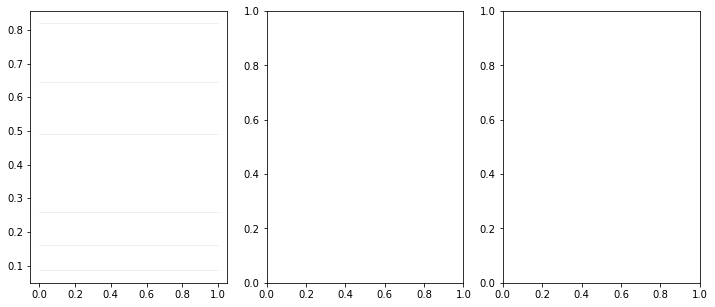

In [35]:
_, axes = plt.subplots(1, 3, figsize=(12, 5))

for s in range(50):
    p = ord_logit_cum_probs(response=range(6), phi=pp_phi[s], a=trace_12_5["cuts"][s])
    
    cur_ax = 0
    for (action, contact), _ in p.groupby(level=["action", "contact"]):
        axes[cur_ax].plot([0,1], p.loc[action, contact], lw=0.6, c="k", alpha=0.1)
        
        if s == 0:
            axes[cur_ax].plot([0, 1], p_obs.loc[action, contact], "ob", alpha=0.4)
            axes[cur_ax].set_xticks([0, 1])
            axes[cur_ax].set_xlabel("intention")
            axes[cur_ax].set_ylabel("probablity")
            axes[cur_ax].set_ylim([0, 1])
            axes[cur_ax].set_title(f"action={action}, contact={contact}")
        cur_ax += 1
plt.tight_layout()